In [2]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf
from scipy.signal import find_peaks

imports work


<span style="font-family: arial; font-size:25px; color:pink">

Open ROOT file and extract data

In [3]:
# hit_data_1096 = rf.get_ROOT_data_zip("TB_FIRE_1096_hits.root")

hit_data_1101 = rf.get_ROOT_data_zip("TB_FIRE_1101_hits.root")

# hit_data_1056 = rf.get_ROOT_data_zip("TB_FIRE_1056_hits.root")

# hit_data_1057 = rf.get_ROOT_data_zip("TB_FIRE_1057_hits.root")

hit_data_1079 = rf.get_ROOT_data_zip("TB_FIRE_1079_hits.root")

TB_FIRE_1101_hits.root finished
TB_FIRE_1079_hits.root finished


<span style="font-family: arial; font-size:25px; color:pink">

Hit Counts and Amp in Single Planes

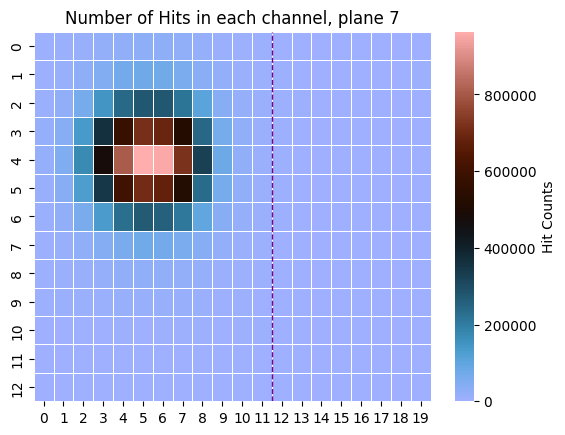

In [4]:
rf.hits_amount_colormap_single_plane(hit_data_1101, 7)

In [5]:
# rf.hits_amount_colormap_single_plane(hit_data_1079, 0)

In [ ]:
# rf.average_amp_colormap_single_plane(hit_data_1101, 7, cmap="managua")

In [ ]:
# rf.average_amp_colormap_single_plane(hit_data_1101, 0, cmap="managua")

<span style="font-family: arial; font-size:25px; color:pink">

Shower Evolution Throughout the Sensor

In [ ]:
# rf.single_event_evolution_amp(hit_data_1101, 54106, cmap="managua")

In [9]:
# plt.clf()   # Clear the current figure
# plt.close() # Close any open figures
# %matplotlib widget
# rf.amp_histo_single_plane(hit_data_1101,1)

In [6]:
# rf.amp_histo_single_plane_total_event(hit_data_1101,0)

In [7]:
# rf.amp_histo_single_plane_total_event(hit_data_1079,0)

amount of hits in plane 0: 2154539
amount of hits in plane 1: 2267642
amount of hits in plane 2: 2299936
amount of hits in plane 3: 2305207
amount of hits in plane 4: 287522
amount of hits in plane 5: 2339654
amount of hits in plane 6: 2333522
amount of hits in plane 7: 2347161


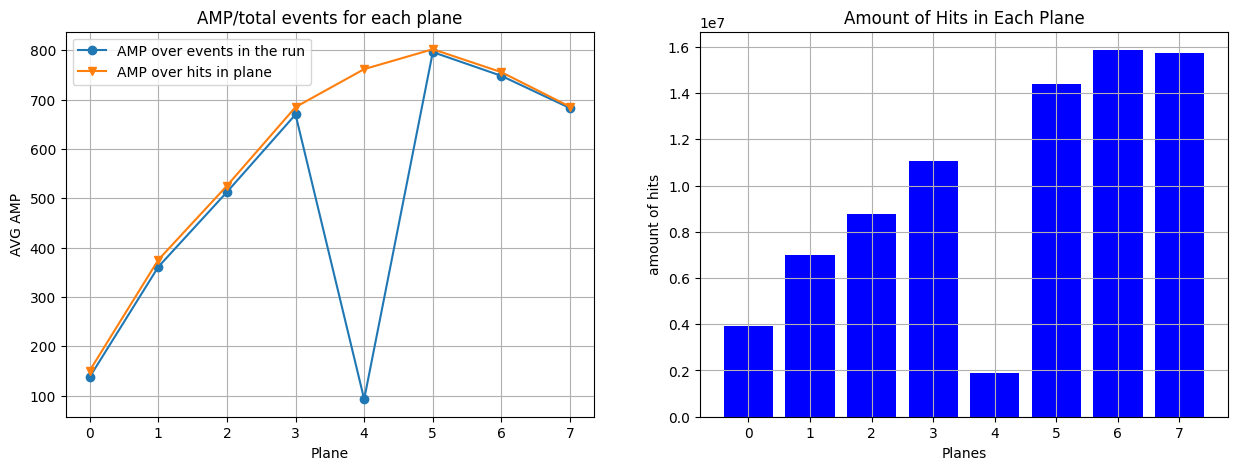

In [ ]:
# rf.average_amp_vs_plane(hit_data_1101)

In [9]:
# # shower initial starting points
# rf.plot_empty_first_planes(hit_data_1101)

<span style="font-family: arial; font-size:25px; color:pink">

Shower Characteeristics relation to initial location.

In [ ]:
# average shower radius
def shower_radius_per_plane_single_event(hit_data, event):

    # find the initial location of the shower
    

In [22]:
a = hit_data_1101[3].ch
divmod(a, 20)


(<Array [8, 9, 9, 9, 10, 10, 10, ..., 11, 11, 8, 9, 9, 8, 9] type='41 * int32'>,
 <Array [4, 3, 4, 5, 2, 3, 6, 3, ..., 18, 19, 4, 3, 4, 4, 4] type='41 * int32'>)